# Practical Measurement of Fairness in Regression Tasks for Healthcare
----

## Overview
This tutorial introduces methods and libraries for measuring fairness in machine learning models as it relates to problems in healthcare, presented in conjunction with the [KDD 2020 Tutorial on Fairness in Machine Learning for Healthcare](https://github.com/KenSciResearch/fairMLHealth/blob/master/publications/FairnessInHealthcareML-KDD-2020.pptx). Through the this noebook you will first learn basic background about fairness metrics", before generating a simple baseline model predicting Length of Stay (LOS) using data from the [MIMIC-III database](https://mimic.physionet.org/gettingstarted/access/). This baseline model will be used as an example to understand common measures like *Disparate Impact Ratios* and *Consistency Scores*. Through this notebook you will gain a familiarity with the Scikit-Learn-compatible tools available in [AIF360](http://aif360.mybluemix.net/) and [FairLearn](https://fairlearn.github.io/), two of the most comprehensive and flexible Python libraries for measuring and addressing bias in machine learning models.

## Tutorial Contents
[Part 0](#part0) - Metrics of Fairness

[Part 1](#part1) - Data Analysis and Model Setup

[Part 2](#part2) - Measuring Fairness

[Part 3](#part3) - Putting it Together


## Tutorial Requirements
This tutorial assumes basic knowledge of machine learning implementation in Python. Before starting, please install [AIF360](http://aif360.mybluemix.net/) and [FairLearn](https://fairlearn.github.io/). Also, ensure that you have installed the Scipy, Pandas, Numpy, Scikit, and XGBOOST libraries.

The tutorial also uses data from the MIMIC III Critical Care database, a freely accessible source of electronic health records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/). Please save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location: you do not need to unzip any files.

----
# Part 0 - Metrics of Fairness <a class="anchor" id="part0"></a>
Here we provide some brief context for the evaluation of fairness in machine learning. For more information, see the [KDD 2020 Tutorial on Fairness in Machine Learning for Healthcare](https://github.com/KenSciResearch/fairMLHealth/blob/master/publications/FairnessInHealthcareML-KDD-2020.pptx).

## What is a "Fair" Model
In the context of this tutorial, a "fair" model is one that imposes no discrimination - the unjustified differential treatment of individuals based on their demographic status. [Romei and Ruggieri (2014)](#romei2014_ref) We refer to these "socially salient" groups ([Speicher 2018](#speicher2018_ref)) as ***protected attributes***, aka. *sensitive attributes* or *protected features*. There are six common metrics for determining whether a given machine learning model meets this definition: Equal Treatment ("Unawareness"), Demographic Parity, Equalized Odds, Predictive Parity, Individual Fairness, and Counterfactual Fairness. Basic definitions for each of these metrics are provided for you in the [Quick Reference](#metric_quickref) below. 

## Disparate Treatment vs Disparate Impact <a id="disparateimpact"></a>
Discussions of discrimination often evoke direct, typically deliberate action to disadvantage one race, religion, or ethnicity. Such explicit action is often referred to as *disparate treatment*. However, a more insidious form of discrimination emerges from ostensibly unbiased practices that result (often unwittingly) in the unfair treatment of a socially disadvantaged group. In machine learning models, such *disparate impact* can emerge, for example, from unconscious collection biases or undetected historical biases in the data. Disparate impact in machine learning can lead either to immediate disparity in model predictions or to a longer-term discrepancy through unconscious human biases in its application. This tutorial focuses on measures to detect the former. However, if you are interested in the latter, we reccomend looking at the [Fairness Indicators](https://www.tensorflow.org/tfx/fairness_indicators) suite released by a team at Google.

##  Fairness Metrics Quick Reference <a id="metric_quickref"></a>
| Metric | Defintion | Weakness | References |
|:------|:------|:------|:------|
|**Unawareness** | A model is unaware if the protected attribute is not used. | Removal of a protected attribute may be ineffectual due to the presence of proxy features highly correlated with the protected attribute.| [Zemel *et al* (2013)](#zemel2013_ref), [Barocas and Selbst (2016)](#barocas2016_ref) |
|**Demographic Parity**| A model has **Demographic Parity** if the prediction is independent of the sensitive feature.<br> $$\dfrac{P(f({X})\geq z \lvert unprivileged)} {P(f({X})\geq \rvert privileged)}$$ | Historical biases present in the data are not addressed and may still bias the model. | [Zafar *et al* (2017)](#zafar2017_ref) |
|**Bounded Group Loss**| A model satisfies bounded group loss at 𝜁 if the average loss is less than gamma for all values of the sensitive feature.<br> $$ \mathbb{E}[{loss(Y, f({X}))}] \leq \gamma, \forall a \in A $$ | 
|**Individual Fairness**| Individual fairness exists if "similar" individuals (ignoring the protected attribute) are likely to have similar predictions. | The appropriate metric for similarity may be ambiguous. |[Dwork (2012)](#dwork2012_ref), [Zemel (2013)](#zemel2013_ref), [Kim *et al* (2018)](#kim2018_ref) |
|**Counterfactual Fairness****| Counterfactual fairness exists where counterfactual replacement of the protected attribute does not significantly alter predictive performance. This counterfactual change must be propogated to correlated variables. | It may be intractable to develop a counterfactual model.  | [Russell *et al* (2017)](#russell2017_ref) |

\** *Note that this tutorial will not elaborate the details of Counterfactual Fairness since the libraries used do not have built-in functionality for it. For an example of Counterfactual Fairness, see "ThemisML" by [Bantilan (2018)](#bantilan2018_ref).*


----
# Part 1 - Model Setup <a class="anchor" id="part1"></a>

This section introduces and loads the data subset that will be used in this tutorial. We will use it to generate a simple baseline model that will be used throughout the tutorial.

In [1]:
# Standard Libraries
from IPython.display import Markdown
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import stats
import sys
import warnings

# Load Prediction Libraries
import sklearn.metrics as sk_metric
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor


# Remove limit to the number of columns and column widths displayed by pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 0) # adjust column width as needed

# Hide Nearest Neighbors warning rising from AIF360 Consistency Score Measure
warnings.filterwarnings('ignore', category=FutureWarning, 
                        message="Pass n_neighbors=5 as keyword args. From version 0.25")

#
np.random.seed(36) 

### Below are helper functions that make the tutorial easier to read

In [2]:
# Helpers from local folder
from fairMLHealth.tools import reports, tutorial_helpers as helpers
bold_on = helpers.cprint.BOLD
bold_cyan =  helpers.cprint.CYAN + bold_on
bold_mgta =  helpers.cprint.MAGENTA + bold_on
cyan_title = helpers.cprint.UNDERLINE + bold_cyan
clr_off = helpers.cprint.OFF

def print_color(text, color_helper):
    return(print(color_helper + text + clr_off))
    

## Loading MIMIC III Data
As mentioned above, the MIMIC-III data download contains a folder of zipped_files. The tutorial code in the [Data Subset](#datasubset) section below will automatically unzip and format all necessary data for these experiments, saving the formatted data in the same MIMIC folder. Simply enter the correct path of the MIMIC folder in the following cell to enable this feature. Your path should end with the directory "MIMIC".

Example: path_to_mimic_data_folder = "~/data/MIMIC"

In [3]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

## Data Subset <a id="datasubset"></a>
Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [4]:
df = helpers.load_mimic3_example(path_to_mimic_data_folder) 
df = df.loc[df['AGE'].ge(65),:]
helpers.print_feature_table(df)
display(Markdown('---'))
display(df.head())


 This data subset has 22434 total observations and 649 input features 



,Raw Feature,Category Count (Encoded Features)
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,2
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20


---

,ADMIT_ID,AGE,GENDER_F,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,ETHNICITY_ASIAN - KOREAN,ETHNICITY_ASIAN - OTHER,ETHNICITY_ASIAN - THAI,ETHNICITY_ASIAN - VIETNAMESE,ETHNICITY_BLACK/AFRICAN,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_BLACK/CAPE VERDEAN,ETHNICITY_BLACK/HAITIAN,ETHNICITY_CARIBBEAN ISLAND,ETHNICITY_HISPANIC OR LATINO,ETHNICITY_HISPANIC/LATINO - CENTRAL AMERICAN (OTHER),ETHNICITY_HISPANIC/LATINO - COLOMBIAN,ETHNICITY_HISPANIC/LATINO - CUBAN,ETHNICITY_HISPANIC/LATINO - DOMINICAN,ETHNICITY_HISPANIC/LATINO - GUATEMALAN,ETHNICITY_HISPANIC/LATINO - HONDURAN,ETHNICITY_HISPANIC/LATINO - MEXICAN,ETHNICITY_HISPANIC/LATINO - PUERTO RICAN,ETHNICITY_HISPANIC/LATINO - SALVADORAN,ETHNICITY_MIDDLE EASTERN,ETHNICITY_MULTI RACE ETHNICITY,ETHNICITY_NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,ETHNICITY_OTHER,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN,LANGUAGE_* BE,LANGUAGE_* FU,LANGUAGE_** T,LANGUAGE_**SH,LANGUAGE_**TO,LANGUAGE_*AMH,LANGUAGE_*ARA,LANGUAGE_*ARM,LANGUAGE_*BEN,LANGUAGE_*BOS,LANGUAGE_*BUL,LANGUAGE_*BUR,LANGUAGE_*CAN,LANGUAGE_*CDI,LANGUAGE_*CHI,LANGUAGE_*DEA,LANGUAGE_*DUT,LANGUAGE_*FAR,LANGUAGE_*FIL,LANGUAGE_*FUL,LANGUAGE_*GUJ,LANGUAGE_*HUN,LANGUAGE_*IBO,LANGUAGE_*KHM,LANGUAGE_*LEB,LANGUAGE_*MAN,LANGUAGE_*MOR,LANGUAGE_*NEP,LANGUAGE_*PER,LANGUAGE_*PHI,LANGUAGE_*PUN,LANGUAGE_*SPA,LANGUAGE_*TAM,LANGUAGE_*TOI,LANGUAGE_*TOY,LANGUAGE_*URD,LANGUAGE_*YID,LANGUAGE_*YOR,LANGUAGE_ALBA,LANGUAGE_AMER,LANGUAGE_ARAB,LANGUAGE_BENG,LANGUAGE_CAMB,LANGUAGE_CANT,LANGUAGE_CAPE,LANGUAGE_ENGL,LANGUAGE_ETHI,LANGUAGE_FREN,LANGUAGE_GREE,LANGUAGE_HAIT,LANGUAGE_HIND,LANGUAGE_ITAL,LANGUAGE_JAPA,LANGUAGE_KORE,LANGUAGE_LAOT,LANGUAGE_MAND,LANGUAGE_PERS,LANGUAGE_POLI,LANGUAGE_PORT,LANGUAGE_PTUN,LANGUAGE_RUSS,LANGUAGE_SERB,LANGUAGE_SOMA,LANGUAGE_SPAN,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Self Pay,MARRIED_DIVORCED,MARRIED_LIFE PARTNER,MARRIED_MARRIED,MARRIED_SEPARATED,MARRIED_SINGLE,MARRIED_UNKNOWN (DEFAULT),MARRIED_WIDOWED,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,DIAGNOSIS_CCS_0,DIAGNOSIS_CCS_1,DIAGNOSIS_CCS_2,DIAGNOSIS_CCS_3,DIAGNOSIS_CCS_4,DIAGNOSIS_CCS_5,DIAGNOSIS_CCS_6,DIAGNOSIS_CCS_7,DIAGNOSIS_CCS_8,DIAGNOSIS_CCS_9,DIAGNOSIS_CCS_10,DIAGNOSIS_CCS_11,DIAGNOSIS_CCS_12,DIAGNOSIS_CCS_13,DIAGNOSIS_CCS_14,DIAGNOSIS_CCS_15,DIAGNOSIS_CCS_16,DIAGNOSIS_CCS_17,DIAGNOSIS_CCS_18,DIAGNOSIS_CCS_19,DIAGNOSIS_CCS_20,DIAGNOSIS_CCS_21,DIAGNOSIS_CCS_22,DIAGNOSIS_CCS_23,DIAGNOSIS_CCS_24,DIAGNOSIS_CCS_25,DIAGNOSIS_CCS_26,DIAGNOSIS_CCS_27,DIAGNOSIS_CCS_28,DIAGNOSIS_CCS_29,DIAGNOSIS_CCS_30,DIAGNOSIS_CCS_31,DIAGNOSIS_CCS_32,DIAGNOSIS_CCS_33,DIAGNOSIS_CCS_34,DIAGNOSIS_CCS_35,DIAGNOSIS_CCS_36,DIAGNOSIS_CCS_37,DIAGNOSIS_CCS_38,DIAGNOSIS_CCS_39,DIAGNOSIS_CCS_40,DIAGNOSIS_CCS_41,DIAGNOSIS_CCS_42,DIAGNOSIS_CCS_43,DIAGNOSIS_CCS_44,DIAGNOSIS_CCS_45,DIAGNOSIS_CCS_46,DIAGNOSIS_CCS_47,DIAGNOSIS_CCS_48,DIAGNOSIS_CCS_49,DIAGNOSIS_CCS_50,DIAGNOSIS_CCS_51,DIAGNOSIS_CCS_52,DIAGNOSIS_CCS_53,DIAGNOSIS_CCS_54,DIAGNOSIS_CCS_55,DIAGNOSIS_CCS_56,DIAGNOSIS_CCS_57,DIAGNOSIS_CCS_58,DIAGNOSIS_CCS_59,DIAGNOSIS_CCS_60,DIAGNOSIS_CCS_61,DIAGNOSIS_CCS_6

## Data Analysis

,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434,9.115200,6.208700,0.004200,4.735200,7.579900,12.017700,29.988900


---

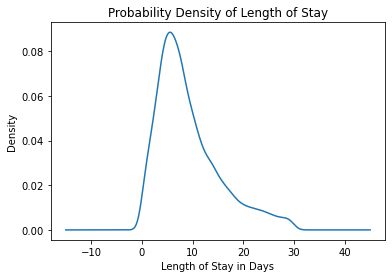

In [5]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val=df['length_of_stay'].mean()
los_tbl = df[['length_of_stay']].describe().transpose().round(4)
los_tbl['count'] = los_tbl['count'].astype(int)
display(los_tbl.style.applymap(helpers.highlight_col, subset=pd.IndexSlice[:, 'mean'], color="aquamarine"
                     ).applymap(helpers.highlight_col, subset=pd.IndexSlice[:, 'count'], color="magenta"
                     ))

# Display LOS distributions
display(Markdown('---'))
ax = df['length_of_stay'].plot(kind='kde', title="Probability Density of Length of Stay")
ax.set_xlabel("Length of Stay in Days")
plt.show()

,count,mean,std,min,25%,50%,75%,max
LANGUAGE_ENGL,,,,,,,,
0,10266,9.587400,6.498900,0.004200,4.911500,7.916700,12.813200,29.979200
1,12168,8.716900,5.923900,0.004900,4.481900,7.217400,11.606900,29.988900


---

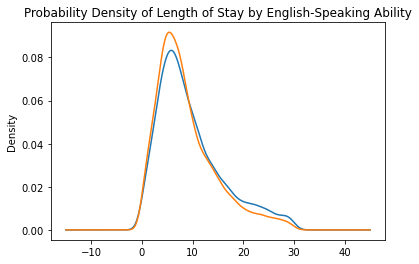

In [6]:
# Update Split Data to Include Language as a Feature
lang_features = ['ETHNICITY', 'LANGUAGE']
lang_cols = [c for c in df.columns if any([c.startswith(f) for f in lang_features])]
X_lang =  df.loc[:,lang_cols]


# Show LOS Statistics Relative to LANG_ENGL
lang_tbl = X_lang.join(df['length_of_stay']).groupby('LANGUAGE_ENGL')['length_of_stay'].describe().round(4)
lang_tbl['count'] = lang_tbl['count'].astype(int)
display(lang_tbl.style.applymap(helpers.highlight_col, subset=pd.IndexSlice[:, 'mean'], color="aquamarine"
                     ).applymap(helpers.highlight_col, subset=pd.IndexSlice[:, 'count'], color="magenta"
                     ))
        
display(Markdown('---'))
ax_e = df.groupby('LANGUAGE_ENGL')['length_of_stay'
                ].plot(kind='kde', title="Probability Density of Length of Stay by English-Speaking Ability")
plt.show()


# Length of Stay Models
The example models in this tutorial predict the total length of time spent in an ICU ward for a given hospital admission, a.k.a. the "Length of Stay" (LOS). The baseline model will use only the patient's age, their diagnosis, and the use of medical procedures during their stay to predict this value. 

Two target variables will be used in the following experiments: 'length_of_stay' and 'long_los'. The length_of_stay target contains the true value in days for the patient's stay in ICU. The long_los target is a binary variable indicating whether or not the length_of_stay for a given admission is greater than the mean. Observations have been dropped where LOS values are extremely long (30 days or greater) or negative (indicating that the patient was deceased upon arrival at the ICU). We will generate variable below, then generate our baseline model.

## Model without Language Feature

In [7]:
# Subset and Split Data
features = ['AGE', 'INSURANCE', 'DIAGNOSIS', 'PROCEDURE']
X = df.loc[:,[c for c in df.columns if any([c.startswith(f) for f in features])]]
y = df.loc[:, ['length_of_stay']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)


In [8]:
# Set model parameters (defined here for consistency throughout models)
xgb_params = {'reg':"squarederror"}

# Train Model
baseline_model = XGBRegressor(**xgb_params)
baseline_model.fit(X_train, y_train.iloc[:,0])
y_pred_baseline = baseline_model.predict(X_test)


print("\n", "Prediction Scores for Baseline Model:") 
        reports.regression_performance(y_test, y_pred_baseline)

[16:14:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { reg } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



 Prediction Scores for Baseline Model:


,Score
Rsqrd,0.479053
MeanAE,3.258444
MeanSE,19.675650


## Model with Language Feature

In [9]:
# Train New Model with Language Feature
X_train_lang = X_train.join(X_lang, how='inner')
X_test_lang = X_test.join(X_lang, how='inner')

#
xgb_params = {}
lang_model = XGBRegressor(**xgb_params)
lang_model.fit(X_train_lang, y_train.iloc[:,0])
y_pred_lang = lang_model.predict(X_test_lang)

#
print("\n", "Prediction Scores for Baseline Model:") 
        reports.regression_performance(y_test, y_pred_baseline)


 Prediction Scores for Baseline Model:


,Score
Rsqrd,0.479053
MeanAE,3.258444
MeanSE,19.675650


----
# Part 2 - Measuring Fairness with AIF360 <a class="anchor" id="part2"></a>
## Getting Started

In [10]:
# Generate target dataframes specifically formatted as inputs for AIF360
y_test_aif = pd.concat([X_test_lang['LANGUAGE_ENGL'], y_test], axis=1).set_index('LANGUAGE_ENGL')
y_pred_aif = pd.concat([X_test_lang['LANGUAGE_ENGL'].reset_index(drop=True), pd.Series(y_pred_lang)], axis=1).set_index('LANGUAGE_ENGL')
y_pred_aif.columns = y_test_aif.columns
print(bold_on + "AIF360 formatting added." + clr_off)
y_pred_aif.head(3)

AIF360 formatting added.


,length_of_stay
LANGUAGE_ENGL,
0,9.032152
0,7.699770
1,16.996422


In [11]:
X_test_lang['LANGUAGE_ENGL'].describe().transpose()

count    5609.000000
mean     0.545195   
std      0.497998   
min      0.000000   
25%      0.000000   
50%      1.000000   
75%      1.000000   
max      1.000000   
Name: LANGUAGE_ENGL, dtype: float64

## Measures of Fairness by Group

A model has **Demographic Parity** if the predicted positve rates (selection rates) are approximately the same for all protected attribute groups. 

### Statistical Parity Ratio 
A corollary to the Demographic Parity Ratio for binary classification problems.

> $ statistical\_parity\_ratio = \dfrac{\mathbb{E}[h(X)\ | unprivileged]}{\mathbb{E}[h(X)\ | priveleged]}$


In [12]:
from aif360.sklearn.metrics import ratio

def statistical_parity_ratio(y_true, y_pred, prot_attr, weights=None, priv_group=1):
    """ Returns the ratio of the expected values between the privileged and
        unpriveleged group
    """
    def expected_value(pdSeries, weights): return(pdSeries.apply(np.average)[0])
    spr = ratio(expected_value, y_true, y_pred, prot_attr=prot_attr, priv_group=priv_group)
    return(spr)


In [13]:
print_color("Statistical Parity", bold_mgta)
print("\t", "Statistical Parity Ratio =", statistical_parity_ratio(y_test_aif, y_pred_aif, 'LANGUAGE_ENGL') )

Statistical Parity
	 Statistical Parity Ratio = 1.1214167088769829


## Group Loss Comparison

A model satisfies bounded group loss at 𝜁 if the average loss is less than gamma for all values of the sensitive feature.
> $$ \mathbb{E}[{loss(Y, f({X}))}] \leq \gamma, \forall a \in A $$

### MSE Ratio
> $ MSE Ratio = \dfrac{MSE_{unprivileged}}{MSE_{priveleged}} $
Here we compare in-group loss values as they are calculated by our model. Since our example model uses the squared error, we compare the in-group mean values of the squared erros.

In [16]:
from fairlearn.metrics import mean_squared_error_group_summary, difference_from_summary

mae_summary = mean_squared_error_group_summary(y_test, y_pred_lang, sensitive_features=X_test_lang['LANGUAGE_ENGL'])
print_color("Measuring Group Loss", bold_mgta)
print("\t", "MSE Ratio =", mae_summary['by_group'][0]/mae_summary['by_group'][1])



Measuring Group Loss
	 MSE Ratio = 1.2421663053057599


## Measures of Fairness by Individual
Measures of individual fairness determine if "similar" individuals (ignoring the protected attribute) are likely to have similar predictions.

### Consistency Scores <a id="consistency_score"></a>
Consistency scores are measure the similarity between specific predictions and the predictions of like individuals. They are not specific to a particular attribute, but rather they evaluate the generally equal treatment of equal individuals. In AIF360, the Consistency Score is calculated as the compliment of the mean distance to the score of the mean nearest neighbhor, using Scikit's Nearest Neighbors algorithm (default: 5 neighbors determined by BallTree algorithm). For this measure, values closer to 1 indicate greater consistency, and those closer to zero indicate less consistency. More information about consistency scores is available in [Zemel (2013)](#zemel2013_ref).
> $ consistency\_score = 1 - \frac{1}{n\cdot\text{n_neighbors}}\sum_{i=1}^n |\hat{y}_i - \sum_{j\in\mathcal{N}_{\text{n_neighbors}}(x_i)} \hat{y}_j| $


In [17]:
from aif360.sklearn.metrics import consistency_score

print_color("Nearest Neighbors-Based Consistency", bold_mgta)
print("\t", "Consistency Score =", consistency_score(X_test_lang, y_pred_lang))


Nearest Neighbors-Based Consistency
	 Consistency Score = -1.4483006000518799


----
# Part 3 - Putting it Together  <a class="anchor" id="part3"></a>


## FairMLHEalth Comparison Tool

In [18]:
#
lang_values = X_test_lang[['LANGUAGE_ENGL']]

# Use Tutorial Helper Function to Generate Dataframe of Measure Values for Gender-Included Model, Relative to Patient Gender
baseline_scores = reports.report_regression_fairness(X_test, lang_values, y_test, y_pred_baseline)
baseline_scores.columns = ["Baseline Value"]
lang_scores = reports.report_regression_fairness(X_test_lang, lang_values, y_test, y_pred_lang)
lang_scores.columns = ["Value with Language"]

table = pd.concat([baseline_scores, lang_scores], axis=1)
reports.flag_suspicous(table)


## FairLearn Dashboard

In [19]:
# (Optional) View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=X_test_lang['LANGUAGE_ENGL'], 
                   sensitive_feature_names=['LANGUAGE_ENGL'],
                   y_true=y_test,
                   y_pred=y_pred_baseline)

FairlearnWidget(value={'true_y': [[7.808333333333334], [7.927083333333332], [18.73680555555556], [7.8923611111…

----
# References 
<a id="agniel2018biases"></a>
Agniel D, Kohane IS, & Weber GM (2018). Biases in electronic health record data due to processes within the healthcare system: retrospective observational study. Bmj, 361. Available at [https://www.bmj.com/content/361/bmj.k1479](https://www.bmj.com/content/361/bmj.k1479)

<a id="bantilan2018_ref"></a>
Bantilan N (2018). Themis-ml: A fairness-aware machine learning interface for end-to-end discrimination discovery and mitigation. Journal of Technology in Human Services, 36(1), 15-30. Available at [https://www.tandfonline.com/doi/abs/10.1080/15228835.2017.1416512](https://www.tandfonline.com/doi/abs/10.1080/15228835.2017.1416512) 

<a id="barocas2016_ref"></a>
Barocas S, & Selbst AD (2016). Big data's disparate impact. California Law Review, 104, 671. Available at [http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf](http://www.californialawreview.org/wp-content/uploads/2016/06/2Barocas-Selbst.pdf) 

Bellamy RK, Dey K, Hind M, Hoffman SC, Houde S, Kannan K, ... & Nagar S (2018). AI Fairness 360: An extensible toolkit for detecting, understanding, and mitigating unwanted algorithmic bias. arXiv Preprint. [arXiv:1810.01943.](https://arxiv.org/abs/1810.01943). See Also [AIF360 Documentation](http://aif360.mybluemix.net/) 

Bird S, Dudík M,  Wallach H,  & Walker K (2020). Fairlearn: A toolkit for assessing and improving fairness in AI. Microsoft Research. Available at [https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf](https://www.microsoft.com/en-us/research/uploads/prod/2020/05/Fairlearn_whitepaper.pdf). See Also [FairLearn Reference](https://fairlearn.github.io/).

<a id="dwork2012_ref"></a>
Dwork C, Hardt M, Pitassi T, Reingold O, & Zemel R (2012, January). Fairness through awareness. In Proceedings of the 3rd innovations in theoretical computer science conference (pp. 214-226). Available at [https://arxiv.org/pdf/1104.3913.pdf](https://arxiv.org/pdf/1104.3913.pdf) 

<a id="fourfifths_ref"></a>
Equal Employment Opportunity Commission, & Civil Service Commission, Department of Labor & Department of Justice (1978). Uniform guidelines on employee selection procedures. Federal Register, 43(166), 38290-38315. Available at [http://uniformguidelines.com/uniformguidelines.html#18](http://uniformguidelines.com/uniformguidelines.html#18) 

<a id="hardt2016_ref"></a>
Hardt M, Price E, & Srebro N (2016). Equality of opportunity in supervised learning. In Advances in neural information processing systems (pp. 3315-3323). Available at [http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf](http://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning.pdf) 

<a id="hcup_ref"></a>
Healthcare Cost and Utilization Project (HCUP) (2017, March). HCUP CCS. Agency for Healthcare Research and Quality, Rockville, MD. Available at [www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)  

Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, & Mark RG (2016). Scientific Data. MIMIC-III, a freely accessible critical care database. DOI: 10.1038/sdata.2016.35. Available at [http://www.nature.com/articles/sdata201635](http://www.nature.com/articles/sdata201635)

<a id="kim2018_ref"></a>
Kim M, Reingol O, & Rothblum G (2018). Fairness through computationally-bounded awareness. In Advances in Neural Information Processing Systems (pp. 4842-4852). Available at [https://arxiv.org/pdf/1803.03239.pdf](https://arxiv.org/pdf/1803.03239.pdf)   

<a id="romei2014_ref"></a>
Romei, A., & Ruggieri, S. (2014). A multidisciplinary survey on discrimination analysis. The Knowledge Engineering Review, 29(5), 582-638. Available at [https://www.cambridge.org/core/journals/knowledge-engineering-review/article/multidisciplinary-survey-on-discrimination-analysis/D69E925AC96CDEC643C18A07F2A326D7](https://www.cambridge.org/core/journals/knowledge-engineering-review/article/multidisciplinary-survey-on-discrimination-analysis/D69E925AC96CDEC643C18A07F2A326D7)   

<a id="russell2017_ref"></a>
Russell C, Kusner MJ, Loftus J, & Silva R (2017). When worlds collide: integrating different counterfactual assumptions in fairness. In Advances in Neural Information Processing Systems (pp. 6414-6423). Available at [https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf](https://papers.nips.cc/paper/7220-when-worlds-collide-integrating-different-counterfactual-assumptions-in-fairness.pdf)  

<a id="shorrocks_ref"></a>
Shorrocks AF (1980). The class of additively decomposable inequality measures. Econometrica: Journal of the Econometric Society, 613-625. Available at [http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf](http://www.vcharite.univ-mrs.fr/PP/lubrano/atelier/shorrocks1980.pdf) 

<a id="speicher2018_ref"></a>
Speicher T, Heidari H, Grgic-Hlaca N, Gummadi KP, Singla A, Weller A, & Zafar M B (2018, July). A unified approach to quantifying algorithmic unfairness: Measuring individual &group unfairness via inequality indices. In Proceedings of the 24th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining (pp. 2239-2248). Available at [https://arxiv.org/pdf/1807.00787.pdf](https://arxiv.org/pdf/1807.00787.pdf) 

<a id="zemel2013_ref"></a>
Zemel R, Wu Y, Swersky K, Pitassi T, & Dwork C (2013, February). Learning fair representations. International Conference on Machine Learning (pp. 325-333). Available at [http://proceedings.mlr.press/v28/zemel13.pdf](http://proceedings.mlr.press/v28/zemel13.pdf) 

<a id="zafar2017_ref"></a>
Zafar MB, Valera I, Gomez Rodriguez, M, & Gummadi KP (2017, April). Fairness beyond disparate treatment & disparate impact: Learning classification without disparate mistreatment. In Proceedings of the 26th international conference on world wide web (pp. 1171-1180).  https://arxiv.org/pdf/1610.08452.pdf 



# Additional Resources and Tutorials <a id="additional_resources"></a>

[Fairness Indicators](https://www.tensorflow.org/tfx/fairness_indicators) - A TensorFlow-enabled suite designed for simulation of long-term effects caused by the implementation of a machine learning model.   

["A Tutorial on Fairness in Machine Learning" by Ziyuan Zhong](https://towardsdatascience.com/a-tutorial-on-fairness-in-machine-learning-3ff8ba1040cb) - A popular reference with additional background on fairness metrics.
   
["How to define fairness to detect and prevent discriminatory outcomes in Machine Learning" by Valeria Cortez](https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2#:~:text=Demographic%20Parity%20states%20that%20the,%E2%80%9Cbeing%20shown%20the%20ad%E2%80%9D) - Another source for background on fairness metrics.


# Table of Fairness-Aware ML Algorithms <a id="mitigation"></a>
The following ML algorithms are available through the libraries discussed in this notebook.

|Algorithm| AIF360 | FairLearn| Reference|
|:----|:----|:----|:----|
|Optimized Preprocessing | Y | - | Calmon et al. (2017) |
|Disparate Impact Remover | Y | - | Feldman et al. (2015) |
|Equalized Odds Postprocessing (Threshold Optimizer) | Y | Y | Hardt et al. (2016) |
|Reweighing | Y | - | Kamiran and Calders (2012) |
|Reject Option Classification | Y | - | Kamiran et al. (2012) |
|Prejudice Remover Regularizer | Y | - | Kamishima et al. (2012) |
|Calibrated Equalized Odds Postprocessing | Y | - | Pleiss et al. (2017) |
|Learning Fair Representations | Y | - | [Zemel (2013)](#zemel2013_ref) |
|Adversarial Debiasing | Y | - | Zhang et al. (2018 |
|Meta-Algorithm for Fair Classification | Y | - | Celis et al. (2018) |
|Rich Subgroup Fairness | Y | - | Kearns, Neel, Roth, & Wu (2018) |
|Exponentiated Gradient | - | Y | Agarwal, Beygelzimer, Dudik, Langford, & Wallach (2018) |
|Grid Search | - | Y |  Agarwal, Dudik, & Wu (2019); Agarwal, Beygelzimer, Dudik, Langford, & Wallach (2018) |
